In [52]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
from IPython.display import display, clear_output
import os 
from pathlib import Path
import uproot
import pandas as pd

In [53]:
#Using a simualted phantom and sinogram

'''true_object = shepp_logan_phantom()
activity_level = 0.1
true_object = rescale(activity_level * true_object, 0.5)

#Forward project true object to generate simulated sinogram data 

azi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles
sinogram = radon(true_object, azi_angles, circle=False)'''


'true_object = shepp_logan_phantom()\nactivity_level = 0.1\ntrue_object = rescale(activity_level * true_object, 0.5)\n\n#Forward project true object to generate simulated sinogram data \n\nazi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles\nsinogram = radon(true_object, azi_angles, circle=False)'

In [54]:
# Load data
cwd = os.getcwd()
folder = Path(cwd) / "output"
filename = os.path.join(folder, "output_philips.root")
f = uproot.open(filename)
hits = f["Singles1"]

# Load relevant branches
arrays = hits.arrays([
    "PostPosition_X", "PostPosition_Y", "PostPosition_Z", 
    "TotalEnergyDeposit", "GlobalTime"
], library="np")

# Combine into DataFrame
df = pd.DataFrame(arrays)
print(f"Loaded {len(df)} hits.")

df.head()
print(df.shape)

Loaded 12764007 hits.
(12764007, 5)


In [55]:
'''#Using data from GATE

# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / "output"
if (not folder.is_dir()):
    print(f"ERROR: {folder} is not a folder.")
print(f"The Current Working Directory (CWD) is {cwd}")
print(f"The output folder is {folder}")

#filename = os.path.join(folder, "output_pet.root")
filename = os.path.join(folder, "output_philips.root")
#filename = os.path.join(folder, "output_picopet.root")
f = uproot.open(filename)

# print the list of trees
for t in f:
    print(f'Tree {t}')

# get the first tree and print the branches
hits = f['Singles1']

arrays = hits.arrays(["PostPosition_X", "PostPosition_Y", "PostPosition_Z", "TotalEnergyDeposit",  "GlobalTime", "LocalTime", "PreStepUniqueVolumeID"], library="np")

# Convert to DataFrame manually
df = pd.DataFrame({
    "PostPosition_X": arrays["PostPosition_X"],
    "PostPosition_Y": arrays["PostPosition_Y"],
    "PostPosition_Z": arrays["PostPosition_Z"],
    "TotalEnergyDeposit": arrays["TotalEnergyDeposit"],
    "GlobalTime": arrays["GlobalTime"],
    "LocalTime": arrays["LocalTime"],
    "PreStepUniqueVolumeID": arrays["PreStepUniqueVolumeID"]
})

print(f'Number of hits : {hits.num_entries}')
for b in hits:
    print(f'Branch {b.name}')

df.head()
print(df.shape)'''

'#Using data from GATE\n\n# The following command display the current working directory (where jupyter has been launched)\n# and select the output folder\ncwd = os.getcwd()\nfolder = Path(cwd) / "output"\nif (not folder.is_dir()):\n    print(f"ERROR: {folder} is not a folder.")\nprint(f"The Current Working Directory (CWD) is {cwd}")\nprint(f"The output folder is {folder}")\n\n#filename = os.path.join(folder, "output_pet.root")\nfilename = os.path.join(folder, "output_philips.root")\n#filename = os.path.join(folder, "output_picopet.root")\nf = uproot.open(filename)\n\n# print the list of trees\nfor t in f:\n    print(f\'Tree {t}\')\n\n# get the first tree and print the branches\nhits = f[\'Singles1\']\n\narrays = hits.arrays(["PostPosition_X", "PostPosition_Y", "PostPosition_Z", "TotalEnergyDeposit",  "GlobalTime", "LocalTime", "PreStepUniqueVolumeID"], library="np")\n\n# Convert to DataFrame manually\ndf = pd.DataFrame({\n    "PostPosition_X": arrays["PostPosition_X"],\n    "PostPositi

In [56]:
def find_coincidences(df: pd.DataFrame, time_window: float) -> pd.DataFrame:
    """
    Find photon coincidences within a given time window.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing photon measurements with the columns:
                           ["PostPosition_X", "PostPosition_Y", "PostPosition_Z",
                            "TotalEnergyDeposit", "GlobalTime", "LocalTime"].
        time_window (float): Maximum allowed time difference between photon pairs.
        
    Returns:
        pd.DataFrame: DataFrame where each row represents a coincidence pair.
                      The columns are the original attributes suffixed with _1 and _2.
    """
    # Sort the dataframe by GlobalTime for an efficient sliding-window search.
    df_sorted = df.sort_values("GlobalTime").reset_index(drop=True)
    times = df_sorted["GlobalTime"].values
    energies = df_sorted["TotalEnergyDeposit"]
    n = len(df_sorted)
    coincidences = []

    # Define energy window
    energy_lower = 0.511 - 0.030
    energy_upper = 0.511 + 0.030

    #With energy limit
    '''for i in range(n):
        j = np.searchsorted(times, times[i] + time_window, side='right')

        if energy_lower <= energies[i] <= energy_upper:
            for k in range(i + 1, j):
                if energy_lower <= energies[k] <= energy_upper:
                    pair = {}
                    for col in df_sorted.columns:
                        pair[f"{col}_1"] = df_sorted.iloc[i][col]
                        pair[f"{col}_2"] = df_sorted.iloc[k][col]

                    pair["TOF_Difference"] = df_sorted.iloc[k]["GlobalTime"] - df_sorted.iloc[i]["GlobalTime"]
                    coincidences.append(pair)'''
    
    #Without energy cut
    for i in range(n):
        j = np.searchsorted(times, times[i] + time_window, side='right')

        for k in range(i + 1, j):
            pair = {}
            for col in df_sorted.columns:
                pair[f"{col}_1"] = df_sorted.iloc[i][col]
                pair[f"{col}_2"] = df_sorted.iloc[k][col]

            pair["TOF_Difference"] = df_sorted.iloc[k]["GlobalTime"] - df_sorted.iloc[i]["GlobalTime"]
            coincidences.append(pair)


    
    return pd.DataFrame(coincidences)

In [57]:
time_window = 1.5  # example time window value
coincidences_df = find_coincidences(df, time_window)
print(coincidences_df.head())
print("Number of coincidences =  " + str(coincidences_df.shape[0]))

   PostPosition_X_1  PostPosition_X_2  PostPosition_Y_1  PostPosition_Y_2  \
0       -329.836446        182.083625       -211.706518       -350.352578   
1        321.411446       -352.261446        226.299046       -172.865279   
2        370.686446       -380.268989        140.952243        -97.946037   
3         -6.425000         59.275000        391.500000       -391.500000   
4        319.411446       -167.048543       -229.763148       -355.824900   

   PostPosition_Z_1  PostPosition_Z_2  TotalEnergyDeposit_1  \
0              6.00            -51.70              0.236147   
1            -34.85             59.70              0.510999   
2             42.85            -26.85              0.510999   
3             34.85            -67.70              0.510999   
4            -42.85            -59.70              0.180787   

   TotalEnergyDeposit_2  GlobalTime_1  GlobalTime_2  TOF_Difference  
0              0.134617     37.950537     38.429123        0.478586  
1              0.5

In [58]:
#Defining the 3D Voxel grid

vox_size = 2 # Defining voxel size (mm)
volume_mm = (200, 200, 32)

voxDim = tuple(int(length / vox_size) for length in volume_mm) # (150, 150, 16)

voxel_grid = np.ones(voxDim, dtype=np.float32)
#print(voxel_grid)

voxel_origin_mm = np.array([ 
    -volume_mm[0] / 2 + vox_size, 
    -volume_mm[1] / 2 + vox_size,
    -volume_mm[2] / 2 + vox_size
]) #centres the voxel grid around (0, 0, 0) in world coordinates

time_threshold_ns = 0.7 #chose this because it should be the max time difference if a decay occurs at the circumference of the r = 100mm circle
#ensures only physically plausible pairs are considered

##Loop over LORs and find interesting voxels


In [59]:
def clip_lor_to_grid(p1, p2, origin, voxel_size, grid_shape):
    grid_min = origin
    grid_max = origin + np.array(grid_shape) * voxel_size
    direction = p2 - p1

    with np.errstate(divide='ignore', invalid='ignore'):
        tmin = (grid_min - p1) / direction
        tmax = (grid_max - p1) / direction

    t1 = np.minimum(tmin, tmax)
    t2 = np.maximum(tmin, tmax)

    t_enter = np.nanmax(t1)
    t_exit = np.nanmin(t2)

    if t_enter > t_exit or t_exit < 0 or t_enter > 1:
        return None, None  # no intersection

    # Clamp to [0, 1] range of original segment
    t0 = max(t_enter, 0)
    t1 = min(t_exit, 1)

    clipped_p1 = p1 + t0 * direction
    clipped_p2 = p1 + t1 * direction

    return clipped_p1, clipped_p2


In [60]:
#Function to sample along LOR - find out which voxels a LOR goes through and also weight it based on how much of the voxel it passes through

def get_voxel_indices(p1, p2, origin, voxel_size, grid_shape):

    '''This function computes which voxels the LOR intersects with and how far the LOR travels in each voxel'''

    #Convert the start and end points form mm into voxel space
    p1_voxel = (p1 - origin) / voxel_size
    p2_voxel = (p2 - origin) / voxel_size

    #Define LOR direction and total length
    direction = p2_voxel - p1_voxel
    length_total = np.linalg.norm(direction)
    if length_total == 0:
        return []
    
    #Normalise the direction 
    direction_unit = direction / length_total

    #Prepare voxel grid and start at the correct voxel 
    nx, ny, nz = grid_shape
    current_voxel = np.floor(p1_voxel).astype(int)

    voxels = []
    t_max = np.zeros(3)
    t_delta = np.zeros(3)
    step = np.zeros(3, dtype=int)

    for i in range(3):
        if direction_unit[i] > 0:
            step[i] = 1
            next_voxel_boundary = (current_voxel[i] + 1) * 1.0
        else:
            step[i] = -1
            next_voxel_boundary = current_voxel[i] * 1.0

        if direction_unit[i] != 0:
            t_max[i] = (next_voxel_boundary - p1_voxel[i]) / direction_unit[i]
            t_delta[i] = abs(1.0 / direction_unit[i])
        else:
            t_max[i] = np.inf
            t_delta[i] = np.inf
            
    t = 0.0
    while t <= length_total:
        i, j, k = current_voxel
        if 0 <= i < nx and 0 <= j < ny and 0 <= k < nz:
            t_next = min(t_max)
            path_length = (t_next - t) * np.linalg.norm(voxel_size * direction_unit)
            voxels.append((i, j, k, path_length))
        else:
            break  # outside grid

        # Advance to next voxel
        axis = np.argmin(t_max)
        t = t_max[axis]
        t_max[axis] += t_delta[axis]
        current_voxel[axis] += step[axis]

    return voxels



In [61]:
#Getting LOR list
lor_list = []

for _, row in coincidences_df.iterrows():
    p1 = np.array([row["PostPosition_X_1"], row["PostPosition_Y_1"], row["PostPosition_Z_1"]])
    p2 = np.array([row["PostPosition_X_2"], row["PostPosition_Y_2"], row["PostPosition_Z_2"]])
    lor_list.append((p1, p2))

In [62]:
#Creating an empty sensitivity map
measured_dat = np.zeros_like(voxel_grid)

for p1, p2 in lor_list:

    p1_clipped, p2_clipped = clip_lor_to_grid(p1, p2, voxel_origin_mm, vox_size, voxDim)
    if p1_clipped is None:
        continue
    voxels = get_voxel_indices(p1_clipped, p2_clipped, voxel_origin_mm, vox_size, voxDim)

    if voxels:  # only process if at least one voxel was hit
        for i, j, k, path_length in voxels:
            measured_dat[i, j, k] += path_length  # or += 1 if you want constant weight


/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

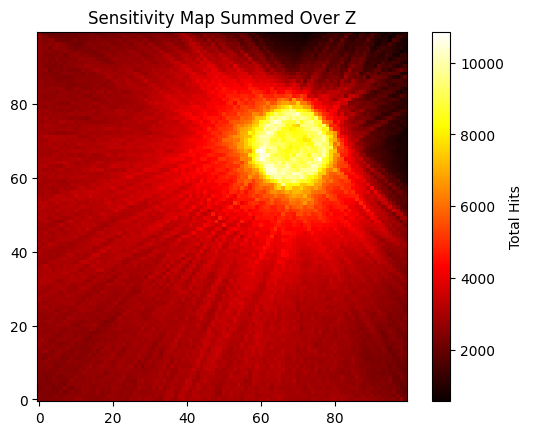

In [63]:
#Sensitivity map, shows how often voxel j is seen by all LORs

plt.imshow(np.sum(measured_dat, axis=2).T, cmap='hot', origin='lower')
plt.title("Sensitivity Map Summed Over Z")
plt.colorbar(label="Total Hits")

In [64]:
from scipy.ndimage import gaussian_filter

# --- Parameters ---
num_iterations = 10
epsilon = 1e-6  # small constant to avoid division by 0

# --- Initialize ---
image_estimate = np.ones_like(voxel_grid)
#image_estimate /= np.sum(image_estimate)  # Option A: normalize initial guess


for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}")
    numerator = np.zeros_like(voxel_grid)

    for p1, p2 in lor_list:

        p1_clipped, p2_clipped = clip_lor_to_grid(p1, p2, voxel_origin_mm, vox_size, voxDim)
        if p1_clipped is None:
            continue
        voxels = get_voxel_indices(p1_clipped, p2_clipped, voxel_origin_mm, vox_size, voxDim)

        if not voxels:
            continue

        forward_sum = sum(image_estimate[i, j, k] * l for (i, j, k, l) in voxels) + epsilon #forward project x^k
        measured_val = sum(measured_dat[i, j, k] * l for (i, j, k, l) in voxels)

        correction = measured_val / (forward_sum) # m / Ax^k

        for (i, j, k, l) in voxels: #backproject: A^T (1 / Ax^k)
            numerator[i, j, k] += correction * l

    ratio = numerator / (measured_dat + epsilon) #normalise: 1/A^T1 * A^T(1/Ax^k)
    image_estimate = image_estimate * ratio # getting x^(k+1)


Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7


KeyboardInterrupt: 

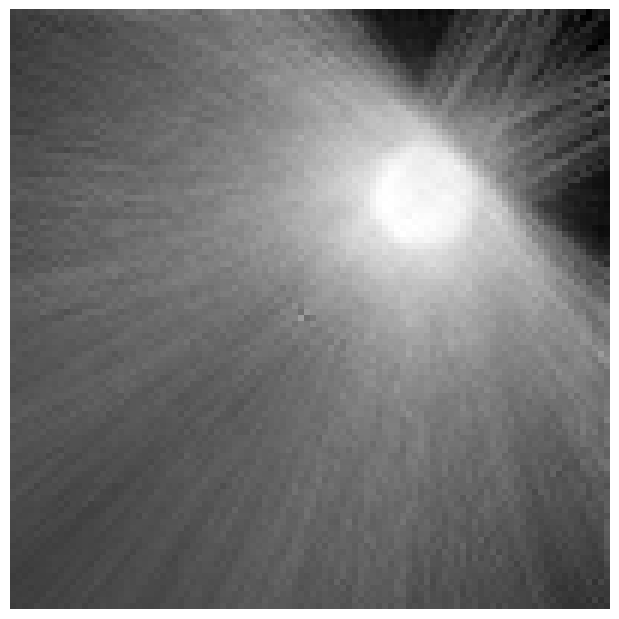

/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("image_estimate.png", dpi=300)
/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("image_estimate.png", dpi=300)
/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("image_estimate.png", dpi=300)
/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDe

In [65]:
# Generate your final image array
projection_image = np.sum(image_estimate, axis=2)

# Plot it in a clean figure
fig = plt.figure(figsize=(6, 6), frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])  # Full canvas usage
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(projection_image.T, cmap='gray', origin='lower')
plt.show()

# Save the image-only output
fig.savefig("image_estimate.png", dpi=300)
plt.close(fig)


In [ ]:
'''def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180,
                     bins_tof: int = 50, tof_resolution: float = 300e-12, use_tof: bool = False):
    """
    Compute the sinogram from coincidence pairs.

    Each line-of-response (LOR) is parameterized by:
      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))
      - r: the perpendicular distance from the origin to the LOR.

    Parameters:
      coincidences_df: DataFrame with coincidence pairs, containing columns:
         'PostPosition_X_1', 'PostPosition_Y_1',
         'PostPosition_X_2', 'PostPosition_Y_2'.
      bins_theta: Number of bins for theta (angles in degrees).
      bins_r: Number of bins for r (distance).
      bins_tof: Number of bins for TOF (if use_tof=True).
      tof_resolution: Detector timing resolution in seconds (e.g., 300 ps).
      use_tof: Whether to include TOF binning.

    Returns:
      sinogram: 2D numpy array (shape: [bins_r, bins_theta]).
      theta_centers: 1D array of theta bin centers (in degrees).
      r_edges: 1D array of r bin edges.
    """
    #Plotting the TOF 3D Sinogram
    thetas = []
    rs = []
    tofs = []
    
    # Calculate sinogram parameters for each coincidence pair.
    for _, row in coincidences_df.iterrows():
        x1 = row["PostPosition_X_1"]
        y1 = row["PostPosition_Y_1"]
        x2 = row["PostPosition_X_2"]
        y2 = row["PostPosition_Y_2"]
        
        # Midpoint of the LOR
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0
        
        # Orientation of the LOR.
        phi = np.arctan2(y2 - y1, x2 - x1)
        
        # Sinogram angle: the normal's angle (wrapped to [0, pi)).
        theta = (phi + np.pi/2) % np.pi
        # Perpendicular distance from the origin.
        r = xm * np.cos(theta) + ym * np.sin(theta)
        
        thetas.append(theta)
        rs.append(r)
        tofs.append(row["TOF_Difference"]) #Storing the TOF differences

    # Convert lists to NumPy arrays
    thetas = np.array(np.degrees(thetas))
    rs = np.array(rs)
    tofs = np.array(tofs)

    combined = np.column_stack((rs, thetas, tofs))
    #print(combined.shape)

    # Compute the 3D TOF-aware sinogram
    sinogram, edges = np.histogramdd(combined, bins=[bins_theta, bins_r, bins_tof])
    
    
    # Choose a tof index (e.g., middle theta bin)
    tof_index = sinogram.shape[2] // 2

    # Extract sinogram slice for the selected theta bin
    sinogram_slice = sinogram[:, :, tof_index]

    # Plot TOF sinogram slice
    plt.figure(figsize=(8, 6))
    plt.imshow(sinogram_slice.T, aspect='auto', origin='lower',
            extent=[edges[1].min(), edges[1].max(), edges[2].min(), edges[2].max()], cmap='gray')

    plt.xlabel("Radial Distance r (mm)")
    plt.ylabel("Theta (radians)")
    plt.title(r"TOF Sinogram at $\Delta{t}$ = " f"{edges[2][tof_index]:.2f} s")
    plt.colorbar(label="Counts")
    plt.show()
    

    #Collapse TOF dimension by summing over TOF bins
    sinogram_2d = np.sum(sinogram, axis = 2)
    print("2D Sinogram Shape:", sinogram_2d.shape)

    theta_centres = (edges[1][:-1] + edges[1][1:]) / 2

    if not use_tof:
        return sinogram_2d, theta_centres
    else:
        #Define TOF resolution (FWHM -> standard deviation)
        tof_fwhm = tof_resolution * 3e8 / 2
        sigma_tof = tof_fwhm / 2.355 # FWHM - SD

        #Initialize weighted sinogram
        sinogram_weighted = np.zeros_like(sinogram_2d)

        #Apply the Gaussian weighting over TOF bins
        for i, tof_bin in enumerate(edges[2]):
            if i == 50: 
                break
            #r_bin = (3e8 * tof_bin) / 2
            weight = np.exp(-((tof_bin)**2) / (2 * sigma_tof **2))
            sinogram_weighted += weight * sinogram[:, :, i] # Apply TOF weight

        return sinogram_weighted, theta_centres'''

'def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180,\n                     bins_tof: int = 50, tof_resolution: float = 300e-12, use_tof: bool = False):\n    """\n    Compute the sinogram from coincidence pairs.\n\n    Each line-of-response (LOR) is parameterized by:\n      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))\n      - r: the perpendicular distance from the origin to the LOR.\n\n    Parameters:\n      coincidences_df: DataFrame with coincidence pairs, containing columns:\n         \'PostPosition_X_1\', \'PostPosition_Y_1\',\n         \'PostPosition_X_2\', \'PostPosition_Y_2\'.\n      bins_theta: Number of bins for theta (angles in degrees).\n      bins_r: Number of bins for r (distance).\n      bins_tof: Number of bins for TOF (if use_tof=True).\n      tof_resolution: Detector timing resolution in seconds (e.g., 300 ps).\n      use_tof: Whether to include TOF binning.\n\n    Returns:\n      sinogram: 2D numpy arr

In [ ]:
'''from skimage.draw import disk

sinogram, theta_centers = compute_sinogram(coincidences_df, bins_theta=360, bins_r=180, use_tof=True)

image_shape = (360, 360)
azi_angles = theta_centers

fig, axs = plt.subplots(1,2, figsize=(10,5))

#axs[0].imshow(true_object, cmap="Greys_r")
#axs[0].set_title('Object')

axs[0].imshow(sinogram.T, cmap="Greys_r") #transpose of sinogram so angle is on y-axis
axs[0].set_title("Sinogram")

#Define reconstructed image
mlem_rec = np.ones(image_shape) #(x^k), iteration 0 (k=0)
mask = np.zeros(image_shape, dtype=bool)
rr, cc = disk((image_shape[0] // 2, image_shape[1] // 2), image_shape[0] // 2)
mask[rr, cc] = True
mlem_rec *= mask
sino_ones = np.ones(sinogram.shape)
sens_image = iradon(sino_ones, azi_angles, circle=True, filter_name=None)

for iter in range(20):  
    fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
    ratio = sinogram / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
    correction = iradon(ratio, azi_angles, circle=True, filter_name=None) / sens_image # No filter because we are just getting the transpose A^T

    axs[1].imshow(mlem_rec, cmap="Greys_r")
    axs[1].set_title("MLEM recon")

    #axs[1, 1].imshow(fp.T, cmap="Greys_r")
    #axs[1, 1].set_title("FP of recon")

    #axs[0, 2].imshow(ratio.T, cmap="Greys_r")
    #axs[0, 2].set_title("Ratio Sinogram")

    #axs[1, 2].imshow(correction, cmap="Greys_r")
    #axs[1, 2].set_title("BP of ratio")

    mlem_rec = mlem_rec * correction

    axs[1].imshow(mlem_rec, cmap="Greys_r")
    axs[1].set_title("MLEM Recon image It=%d" % (iter+1))
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)'''


'from skimage.draw import disk\n\nsinogram, theta_centers = compute_sinogram(coincidences_df, bins_theta=360, bins_r=180, use_tof=True)\n\nimage_shape = (360, 360)\nazi_angles = theta_centers\n\nfig, axs = plt.subplots(1,2, figsize=(10,5))\n\n#axs[0].imshow(true_object, cmap="Greys_r")\n#axs[0].set_title(\'Object\')\n\naxs[0].imshow(sinogram.T, cmap="Greys_r") #transpose of sinogram so angle is on y-axis\naxs[0].set_title("Sinogram")\n\n#Define reconstructed image\nmlem_rec = np.ones(image_shape) #(x^k), iteration 0 (k=0)\nmask = np.zeros(image_shape, dtype=bool)\nrr, cc = disk((image_shape[0] // 2, image_shape[1] // 2), image_shape[0] // 2)\nmask[rr, cc] = True\nmlem_rec *= mask\nsino_ones = np.ones(sinogram.shape)\nsens_image = iradon(sino_ones, azi_angles, circle=True, filter_name=None)\n\nfor iter in range(20):  \n    fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)\n    ratio = sinogram / (fp + 0.000001) #ratio sinogram, tells yo